# First order methods for regression models

## Aim

The aim of this practical is to implement:
- gradient descent (GD);
- accelerated gradient descent (AGD);
- coordinate gradient descent (CD);
- stochastic gradient descent (SGD);
- stochastic average gradient descent (SAG);
- stochastic variance reduced gradient descent (SVRG);

for the linear regression and logistic regression models, with the ridge penalization.

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work, using the **moodle platform**.
- This means that **each student in the pair sends the same file**.

# Gentle reminder: no evaluation if you don't respect this EXACTLY.

## To generate the name of your file, use the following.

In [1]:
# Change here using your first and last names
fn1 = "Ziru"
ln1 = "Niu"
fn2 = "Yunhao"
ln2 = "Chen"


filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp1_niu_ziru_and_chen_yunhao.ipynb


# Table of content

[1. Introduction](#intro)<br>
[2. Models gradients and losses](#models)<br>
[3. Solvers](#solvers)<br>
[4. Comparison of all algorithms](#comparison)<br>

<a id='intro'></a>
# 1. Introduction

## 1.1. Importing useful packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

## 1.2. Simulation of a linear model

In [3]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(w0, n_samples=1000, corr=0.5, std=0.5):
    """Simulation of a linear regression model with Gaussian features
    and a Toeplitz covariance, with Gaussian noise.
    
    Parameters
    ----------
    w0 : `numpy.array`, shape=(n_features,)
        Model weights
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features
    
    std : `float`, default=0.5
        Standard deviation of the noise

    Returns
    -------
    X : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It contains samples of a centered 
        Gaussian  vector with Toeplitz covariance.
    
    y : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    n_features = w0.shape[0]
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    X = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    y = X.dot(w0) + std * randn(n_samples)
    return X, y

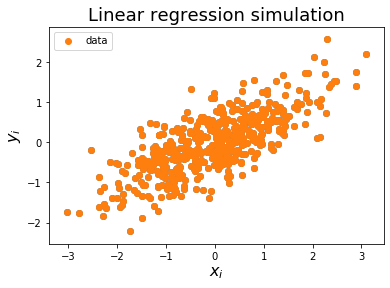

In [4]:
n_samples = 500
w0 = np.array([0.5])

X, y = simu_linreg(w0, n_samples=n_samples, corr=0.3, std=0.5)
plt.scatter(X, y)
plt.xlabel(r"$x_i$", fontsize=16)
plt.ylabel(r"$y_i$", fontsize=16)
plt.title("Linear regression simulation", fontsize=18)
plt.scatter(X, y, label='data')
plt.legend()

## 1.3. Simulation of a logistic regression model

In [5]:
def sigmoid(t):
    """Sigmoid function (overflow-proof)"""
    idx = t > 0
    out = np.empty(t.size)    
    out[idx] = 1 / (1. + np.exp(-t[idx]))
    exp_t = np.exp(t[~idx])
    out[~idx] = exp_t / (1. + exp_t)
    return out

def simu_logreg(w0, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model with Gaussian features
    and a Toeplitz covariance.
    
    Parameters
    ----------
    w0 : `numpy.array`, shape=(n_features,)
        Model weights
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    X : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It contains samples of a centered 
        Gaussian vector with Toeplitz covariance.
    
    y : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    n_features = w0.shape[0]
    cov = toeplitz(corr ** np.arange(0, n_features))
    X = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(X.dot(w0))
    y = np.random.binomial(1, p, size=n_samples)
    # Put the label in {-1, 1}
    y[:] = 2 * y - 1
    return X, y

Text(0.5, 1.0, 'Logistic regression simulation')

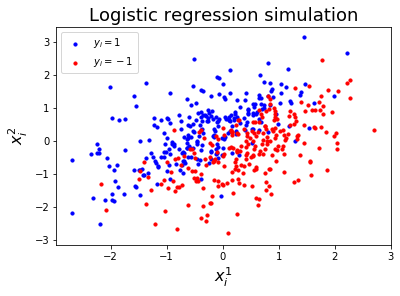

In [6]:
n_samples = 500
w0 = np.array([-3, 3.])

X, y = simu_logreg(w0, n_samples=n_samples, corr=0.4)

plt.scatter(*X[y == 1].T, color='b', s=10, label=r'$y_i=1$')
plt.scatter(*X[y == -1].T, color='r', s=10, label=r'$y_i=-1$')
plt.legend(loc='upper left')
plt.xlabel(r"$x_i^1$", fontsize=16)
plt.ylabel(r"$x_i^2$", fontsize=16)
plt.title("Logistic regression simulation", fontsize=18)

<a id='models'></a>
# 2. Models gradients and losses

We want to minimize a goodness-of-fit function $h : \mathbb R^d \to \mathbb R$ with ridge regularization, namely
$$
\arg\min_{w \in \mathbb R^d} f(w),
\qquad \text{with} \quad
f(w) = h(w) + \frac{\lambda}{2} \|w\|_2^2,
$$
where $d$ is the number of features and where we will assume that $h$ is $L$-smooth.
We will consider below the following cases.

**Linear regression**
$$
f(w)
= \frac{1}{2 n} \| y - X w \|_2^2 + \frac{\lambda}{2} \|w\|_2^2
= \frac 1n \sum_{i=1}^n f_i(w),
\qquad \text{with} \quad
f_i(w) = \frac 12 \left( (y_i - x_i^\top w)^2 + \lambda \|w\|_2^2 \right),
$$
where $n$ is the sample size, $y = [y_1 \cdots y_n]$ is the vector of labels and $X$ is the matrix of features with lines containing the features vectors $x_i \in \mathbb R^d$.

**Logistic regression**
$$
f(w)
= \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-y_i x_i^\top w)) + \frac{\lambda}{2} \|w\|_2^2
= \frac 1n \sum_{i=1}^n f_i(w),
\qquad \text{with} \quad
f_i(w) = \log(1 + \exp(-y_i x_i^\top w)) + \frac{\lambda}{2} \|w\|_2^2,
$$
where $n$ is the sample size, and where labels $y_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f(w)$ and its gradient $\nabla f(w)$ (along with its Lipschitz constant $L$), in order to solve this problem, as well as $\nabla f_i(w)$ (along with the biggest Lipschitz constant $L_{max}$ of $\nabla f_i(w),\dots, \nabla f_n(w)$) for stochastic gradient descent methods and $\frac{\partial f(w)}{\partial w_j}$ (along with its Lipschitz constant $L_j$) for coordinate descent.

Below is the full implementation for linear regression, where:
- `X` is the data matrix $X$;
- `y` is the vector of labels $y$;
- `strength` is the penalty coefficient $\lambda$;
- `loss(w)` computes $f(w)$;
- `grad(w)` computes $\nabla f(w)$;
- `grad_i(i, w)` computes $\nabla f_i(w)$;
- `grad_coordinate(j, w)` computes $\frac{\partial f(w)}{\partial w_j}$;
- `lip()` returns $L$;
- `lip_coordinates()` returns the vector $[L_1, \dots, L_d]$;
- `lip_max()` returns $L_{max}$.

## 2.1 Linear regression

In [7]:
from numpy.linalg import norm


class ModelLinReg:
    """A class giving first order information for linear regression
    with least-squares loss
    
    Parameters
    ----------
    X : `numpy.array`, shape=(n_samples, n_features)
        The features matrix
    
    y : `numpy.array`, shape=(n_samples,)
        The vector of labels
    
    strength : `float`
        The strength of ridge penalization
    """    
    def __init__(self, X, y, strength):
        self.X = X
        self.y = y
        self.strength = strength
        self.n_samples, self.n_features = X.shape

    def loss(self, w):
        """Computes f(w)"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        return 0.5 * norm(y - X.dot(w)) ** 2 / n_samples + strength * norm(w) ** 2 / 2
    
    def grad(self, w):
        """Computes the gradient of f at w"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        return X.T.dot(X.dot(w) - y) / n_samples + strength * w

    def grad_i(self, i, w):
        """Computes the gradient of f_i at w"""
        x_i = self.X[i]
        return (x_i.dot(w) - y[i]) * x_i + self.strength * w

    def grad_coordinate(self, j, w):
        """Computes the partial derivative of f with respect to 
        the j-th coordinate"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        return X[:, j].T.dot(X.dot(w) - y) / n_samples + strength * w[j]

    def lip(self):
        """Computes the Lipschitz constant of the gradient of f"""
        X, n_samples = self.X, self.n_samples
        return norm(X.T.dot(X), 2) / n_samples + self.strength

    def lip_coordinates(self):
        """Computes the Lipschitz constant of the partial derivative of f with respect to 
        the j-th coordinate"""
        X, n_samples = self.X, self.n_samples
        return (X ** 2).sum(axis=0) / n_samples + self.strength
        
    def lip_max(self):
        """Computes the maximum of the lipschitz constants of the gradient of f_i"""
        X, n_samples = self.X, self.n_samples
        return ((X ** 2).sum(axis=1) + self.strength).max()

## 2.2 Checks for the linear regression model

Text(0.5, 1.0, 'Model weights')

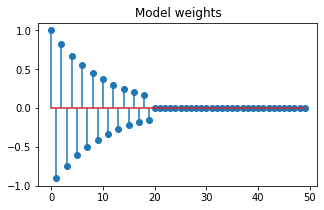

In [8]:
## Simulation setting
n_features = 50
n_informative = 20
idx = np.arange(n_features)
w0 = (-1) ** idx * np.exp(-idx / 10.)
w0[n_informative:] = 0.

plt.figure(figsize=(5, 3))
plt.stem(w0, use_line_collection=True)
plt.title("Model weights")

In [9]:
from scipy.optimize import check_grad

X, y = simu_linreg(w0, corr=0.6)
model = ModelLinReg(X, y, strength=1e-3)

w = np.random.randn(n_features)

print(check_grad(model.loss, model.grad, w)) # This must be a number (of order 1e-6)

4.840319153930884e-06


In [10]:
print("lip =", model.lip())
print("lip_max =", model.lip_max())
print("lip_coordinates =", model.lip_coordinates())

lip = 4.09442905309938
lip_max = 124.85972517212087
lip_coordinates = [1.05 1.06 1.   0.9  0.95 0.94 1.04 1.07 0.98 0.99 0.99 0.98 0.99 0.99
 1.06 0.96 0.98 1.   1.04 1.03 0.98 0.97 0.95 0.92 0.95 0.93 0.9  0.96
 1.   1.07 0.97 0.92 1.04 1.05 1.02 1.04 1.07 1.07 1.   0.99 1.01 0.96
 1.02 1.01 0.98 0.99 0.98 1.1  0.97 1.  ]


## 2.3 Logistic regression

**NB**: you can skip these questions and go to the solvers implementation, and come back here later.

### QUESTIONS

1. Compute (on paper) the gradient $\nabla f$, the gradient of $\nabla f_i$ and the gradient of the coordinate function $\frac{\partial f(w)}{\partial w_j}$ of $f$ for logistic regression (fill the class given below).

2. Fill in the functions below for the computation of $f$, $\nabla f$, $\nabla f_i$ and $\frac{\partial f(w)}{\partial w_j}$ for logistic regression in the ModelLogReg class (fill between `TODO` and `END TODO`).

**Answer:**
…

In [11]:
class ModelLogReg:
    """A class giving first order information for logistic regression
    
    Parameters
    ----------
    X : `numpy.array`, shape=(n_samples, n_features)
        The features matrix
    
    y : `numpy.array`, shape=(n_samples,)
        The vector of labels
    
    strength : `float`
        The strength of ridge penalization
    """    
    def __init__(self, X, y, strength):
        self.X = X
        self.y = y
        self.strength = strength
        self.n_samples, self.n_features = X.shape

In [12]:
from numpy.linalg import norm

In [13]:
# Answer
def LRloss(self, w):
    """Computes f(w)"""
    y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
    ### TODO
    return np.sum(np.log(1 + np.exp(-y * X.dot(w) ))) / n_samples +  0.5 * strength * (norm(w) ** 2)
    #return np.sum(np.log(1 + np.exp(-y*(X@w)))) / n_samples +  0.5 * strength * (w@w) 
    ### END TODO
    
ModelLogReg.loss = LRloss

#answer(LRloss, 1)

In [14]:
# Check the method with fake data
X = np.random.randn(5, 2)
y = np.random.randint(0, 2, X.shape[0])*2 - 1
w = np.random.randn(X.shape[1])

model_logreg = ModelLogReg(X, y, strength=1e-3)

model_logreg.loss(w)

1.1726269817893988

In [15]:
# Answer
def LRgrad(self, w):
    """Computes the gradient of f at w"""
    y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
    ### TODO
    return X.T.dot(-y / (1 + np.exp( y * X.dot(w) ))) / n_samples + strength * w
    ### END TODO
    
ModelLogReg.grad = LRgrad

#answer(LRgrad, 2)

In [16]:
# Check the method
model_logreg.grad(w)

array([-0.57,  0.44])

In [17]:
# Answer
def LRgrad_i(self, i, w):
    """Computes the gradient of f_i at w"""
    x_i = self.X[i]
    ### TODO
    
    return (-y[i] / (1 + np.exp(y[i] * x_i.dot(w) ))) * x_i + self.strength * w

    ### END TODO
    
ModelLogReg.grad_i = LRgrad_i

#answer(LRgrad_i, 3)

In [18]:
# Check the method
model_logreg.grad_i(0, w)

array([-0.74,  1.7 ])

In [19]:
# Answer
def LRgrad_coordinate(self, j, w):
    """Computes the partial derivative of f with respect to 
    the j-th coordinate"""
    y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
    ### TODO
    return  X[:,j].dot( -y / (1 + np.exp(y * X.dot(w) ) )) / n_samples + strength * w[j]
    ### END TODO
    
ModelLogReg.grad_coordinate = LRgrad_coordinate

#answer(LRgrad_coordinate, 4)

In [20]:
# Check the method
model_logreg.grad_coordinate(1, w)

0.4356051448129237

In [21]:
# Answer
def LRlip(self):
    """Computes the Lipschitz constant of the gradient of f"""
    X, n_samples = self.X, self.n_samples
    ### TODO
    return norm(X.T.dot(X), 2) / (4 * n_samples) + self.strength
    ### END TODO
    
ModelLogReg.lip = LRlip

#answer(LRlip, 5)

In [22]:
# Check the method
model_logreg.lip()

0.6423376001938138

In [23]:
# Answer
def LRlip_coordinates(self):
    """Computes the Lipschitz constant of the partial derivative of f with respect to 
    the j-th coordinate"""
    X, n_samples = self.X, self.n_samples
    ### TODO
    return (X ** 2).sum(axis=0) / (4 * n_samples) + self.strength
    ### END TODO
    
ModelLogReg.lip_coordinates = LRlip_coordinates

#answer(LRlip_coordinates, 6)

In [24]:
# Check the method
model_logreg.lip_coordinates()

array([0.31, 0.51])

In [25]:
# Answer
def LRlip_max(self):
    """Computes the maximum of the lipschitz constants of the gradient of f_i"""
    X, n_samples = self.X, self.n_samples
    ### TODO
    return  ((1 / 4) * (X ** 2).sum(axis=1) + self.strength).max()
    ### END TODO
    
ModelLogReg.lip_max = LRlip_max

#answer(LRlip_max, 7)

In [26]:
# Check the method
model_logreg.lip_max()

1.6768043328423134

## 2.4 Checks for the logistic regression model

### QUESTIONS

1. Check numerically the gradient using the function ``checkgrad`` from ``scipy.optimize``, as done for linear regression above.

**Remark**: use the function `simu_logreg` to simulate data according to the logistic regression model.

In [27]:
# Answer
n_features = 50
n_informative = 20

In [28]:
X, y = simu_logreg(w0, corr=0.6)
model = ModelLogReg(X, y, strength=1e-3)

w = np.random.randn(n_features)

print(check_grad(model.loss, model.grad, w)) # This must be a number (of order 1e-6)

1.3706928713107936e-07


<a id='solvers'></a>
## 3. Solvers

We now have classes `ModelLinReg` and `ModelLogReg` that allow to compute $f(w)$, $\nabla f(w)$, 
$\nabla f_i(w)$ and $\frac{\partial f(w)}{\partial w_j}$ for the objective $f$
given by linear and logistic regression.

We want now to implement and compare several solvers to minimize $f$.

<a id='tools'></a>
## 3.1. Tools for the solvers

In [29]:
# Starting point of all solvers
w0 = np.zeros(model.n_features)

# Number of iterations
n_iter = 50

# Random samples indices for the stochastic solvers (sgd, sag, svrg)
idx_samples = np.random.randint(0, model.n_samples, model.n_samples * n_iter)

In [30]:
# Method used to print the objective value at each iteration
# It is not necessary to read/understand it
def inspector(model, n_iter, verbose=True):
    """A closure called to update metrics after each iteration.
    Don't even look at it, we'll just use it in the solvers."""
    objectives = []
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    def inspector_cl(w):
        obj = model.loss(w)
        objectives.append(obj)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8)]))
            it[0] += 1
    inspector_cl.objectives = objectives
    return inspector_cl

<a id='gd'></a>
## 3.2 Gradient descent

### QUESTIONS

1. Finish the function `gd` below that implements the gradient descent algorithm.
1. Test it using the next cell.

In [31]:
# Answer
def gd(model, w0, n_iter, callback, verbose=True):
    """Gradient descent
    """
    step = 1 / model.lip()
    w = w0.copy()
    w_new = w0.copy()
    if verbose:
        print("Lauching GD solver...")
    callback(w)
    for k in range(n_iter + 1):
        ### TODO
        
        w -= step * model.grad(w)
        
        ### END TODO
        callback(w)
    return w

In [32]:
callback_gd = inspector(model, n_iter=n_iter)
w_gd = gd(model, w0, n_iter=n_iter, callback=callback_gd)

Lauching GD solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 5.75e-01
      20 | 5.45e-01
      30 | 5.33e-01
      40 | 5.27e-01
      50 | 5.24e-01


<a id='agd'></a>
## 3.3 Accelerated gradient descent

### QUESTIONS

1. Finish the function `agd` below that implements the accelerated gradient descent algorithm.
1. Test it using the next cell.

In [33]:
# Answer
def agd(model, w0, n_iter, callback, verbose=True):
    """Accelerated gradient descent
    """
    step = 1 / model.lip()
    w = w0.copy()
    # Extra variables are required for acceleration
    z = w0.copy()
    z_new = w0.copy()
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching AGD solver...")
    callback(w)
    for k in range(n_iter + 1):
        ### TODO
        t_new = (1 + np.sqrt(1 + 4 * t ** 2)) / 2
        beta = (t - 1) / t_new
        z_new = w - step * model.grad(w)
        w = z_new + beta * (z_new - z)
        z = z_new.copy()
        t = t_new
        ### END TODO        
        callback(w)
    return w

In [34]:
callback_agd = inspector(model, n_iter=n_iter)
w_agd = agd(model, w0, n_iter=n_iter, callback=callback_agd)

Lauching AGD solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 5.37e-01
      20 | 5.20e-01
      30 | 5.20e-01
      40 | 5.20e-01
      50 | 5.20e-01


<a id='cgd'></a>

## 3.4 Coordinate gradient descent

### QUESTIONS

1. Finish the function `cgd` below that implements the coordinate gradient descent algorithm.
1. Test it using the next cell.

In [35]:
# Answer
def cgd(model, w0, n_iter, callback, verbose=True):
    """Coordinate gradient descent
    """
    w = w0.copy()
    w_new = w0.copy()
    n_features = model.n_features
    steps = 1 / model.lip_coordinates()
    if verbose:
        print("Lauching CGD solver...")
    callback(w)
    for k in range(n_iter + 1):
        ### TODO
        for _ in range(n_features):
            j = np.random.randint(low=0, high=n_features)
            w[j] -= steps[j] * model.grad_coordinate(j,w)

        ### END TODO
        callback(w)
    return w

In [36]:
callback_cgd = inspector(model, n_iter=n_iter)
w_cgd = cgd(model, w0, n_iter=n_iter, callback=callback_cgd)

Lauching CGD solver...
   it    |   obj   
       0 | 6.93e-01
      10 | 5.32e-01
      20 | 5.21e-01
      30 | 5.20e-01
      40 | 5.20e-01
      50 | 5.20e-01


<a id='sgd'></a>
## 3.5. Stochastic gradient descent

### QUESTIONS

1. Finish the function `sgd` below that implements the st stochastic gradient descent algorithm.
1.Test it using the next cell.

In [37]:
# Answer
def sgd(model, w0, idx_samples, n_iter, step, callback, verbose=True):
    """Stochastic gradient descent
    """
    w = w0.copy()
    callback(w)
    n_samples = model.n_samples
    for idx in range(n_iter):
        i = idx_samples[idx]
        ### TODO
        
        w = w - step/np.sqrt(idx+1) * model.grad_i(i,w)
        
        ### END TODO
        if idx % n_samples == 0:
            callback(w)
    return w

In [38]:
step = 1e-1
callback_sgd = inspector(model, n_iter=n_iter)
w_sgd = sgd(model, w0, idx_samples, n_iter=model.n_samples * n_iter, 
            step=step, callback=callback_sgd)

   it    |   obj   
       0 | 6.93e-01
      10 | 5.50e-01
      20 | 5.36e-01
      30 | 5.31e-01
      40 | 5.27e-01
      50 | 5.26e-01


<a id='sag'></a>
## 3.6. Stochastic average gradient descent


### QUESTIONS

1. Finish the function `sag` below that implements the stochastic averaged gradient algorithm.
1. Test it using the next cell

In [39]:
# Answer
def sag(model, w0, idx_samples, n_iter, step, callback, verbose=True):
    """Stochastic average gradient descent
    """
    w = w0.copy()
    n_samples, n_features = model.n_samples, model.n_features
    gradient_memory = np.zeros((n_samples, n_features))
    y = np.zeros(n_features)
    callback(w)
    for idx in range(n_iter):
        i = idx_samples[idx]        
        ### TODO
        
        gradient_memory[i] = model.grad_i(i,w)
        w -= step * np.mean(gradient_memory, axis=0)
        
        ### END TODO        
        if idx % n_samples == 0:
            callback(w)
    return w

In [40]:
step = 1 / model.lip_max()
callback_sag = inspector(model, n_iter=n_iter)
w_sag = sag(model, w0, idx_samples, n_iter=model.n_samples * n_iter, 
            step=step, callback=callback_sag)

   it    |   obj   
       0 | 6.93e-01
      10 | 5.22e-01
      20 | 5.20e-01
      30 | 5.20e-01
      40 | 5.20e-01
      50 | 5.20e-01


<a id='svrg'></a>
## 3.7. Stochastic variance reduced gradient

### QUESTIONS

1. Finish the function `svrg` below that implements the stochastic variance reduced gradient algorithm.
1. Test it using the next cell.

In [41]:
def svrg(model, w0, idx_samples, n_iter, step, callback, verbose=True):
    """Stochastic variance reduced gradient descent
    """
    w = w0.copy()
    w_old = w.copy()
    n_samples = model.n_samples
    callback(w)
    for j in range(int(n_iter / n_samples)):
        mu = model.grad(w)
        for idx in range(n_samples):
            i = idx_samples[idx + j * n_samples]
            w_old -= step * (model.grad_i(i,w_old) - model.grad_i(i, w) + mu)
        w = w_old.copy()
        
        callback(w)
    return w

In [42]:
step = 1 / model.lip_max()
callback_svrg = inspector(model, n_iter=n_iter)
w_svrg = svrg(model, w0, idx_samples, n_iter=model.n_samples * n_iter,
              step=step, callback=callback_svrg)

   it    |   obj   
       0 | 6.93e-01
      10 | 5.20e-01
      20 | 5.20e-01
      30 | 5.20e-01
      40 | 5.20e-01
      50 | 5.20e-01


<a id='comparison'></a>
# 4. Comparison of all algorithms

In [43]:
callbacks = [callback_gd, callback_agd, callback_cgd, callback_sgd, 
             callback_sag, callback_svrg]
names = ["GD", "AGD", "CGD", "SGD", "SAG", "SVRG"]


callback_long = inspector(model, n_iter=1000, verbose=False)
w_cgd = cgd(model, w0, n_iter=1000, callback=callback_long, verbose=False)
obj_min = callback_long.objectives[-1]

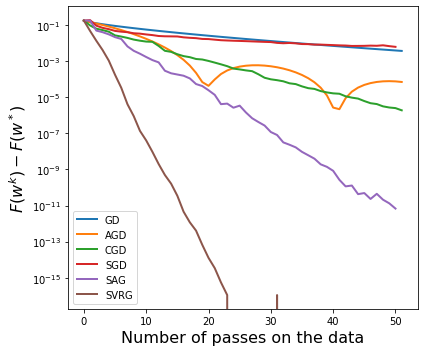

In [44]:
plt.figure(figsize=(6, 5))
plt.yscale("log")

for callback, name in zip(callbacks, names):
    objectives = np.array(callback.objectives)
    objectives_dist = objectives - obj_min    
    plt.plot(objectives_dist, label=name, lw=2)

plt.tight_layout()
#plt.xlim((0, n_iter))
plt.xlabel("Number of passes on the data", fontsize=16)
plt.ylabel(r"$F(w^k) - F(w^*)$", fontsize=16)
plt.legend(loc='lower left')
plt.tight_layout()

### QUESTIONS

1. Compare the minimizers you obtain using the different algorithms, with a large and a small number of iterations. This can be done with `plt.stem` plots.
1. In linear regression and logistic regression, study the influence of the correlation of the features on the performance of the optimization algorithms. Explain.
1. In linear regression and logistic regression, study the influence of the level of ridge penalization on the performance of the optimization algorithms. Explain.
1. (OPTIONAL) All algorithms can be modified to handle an objective of the form $f + g$ with $g$ separable and prox-capable. Modify all the algorithms and try them out for L1 penalization: $w \in \mathbb R^d \mapsto \lambda \sum_{j=1}^d |w_j|$.

# Answer
# Comments on figures

## Question 1: compare the minimizers with different number of iterations

When the number of iterations is small (10, 20 for instance), the coordinates of w from differents algorithms differ a lot. 

After 30 iterations, w begins to converge. We can see that the coordinates of w from different algorithms become very close to each other, except "stochastic gradient descent" (the red points) which does not converge like others.

## Question 2: study the influence of correlation of features

We have printed the mimimizer respectively for each dataset generated with different correlation.

We analyse the converge rate varies in terms of the correlation (for the gradient descent algorithem), we see that, when the correlation augments, the algorithme converges more quickly. And we know that, the number of iteration we need to have a precision $\epsilon$ is as follows:
$$
N_{\epsilon} = O(\frac{L_{lip}|w_* - w_0|_2^2}{\epsilon})
$$
Since in our problem, we have fixed $w_0 = 0$ at the beginning, so finally, we get the formula:
$$
N_{\epsilon} = O(\frac{L_{lip}|w_*|_2^2}{\epsilon})
$$

As we can see above, the order of magnitude of the mimizer (i.e $w_*$) doesn't change a lot in terms of correlation, so we derive that the $L_lip$ is the main factor of the convergence rate, so we only need to show that why $L_lip$ decrases as the correlation increase, and we can give a simple demonstration as follows.

By the law of large number, we know that:
$$
\frac{1}{N_{sample}} X^TX \approx Cov(X)
$$
where X is generated by the given function, if we note the correlation by $\rho$, we know that:
$$
Cov(X) = (1 - \rho) I_m + \rho E_m
$$

where m is the number of features, and $E_m$ is defined as a square matrix in which all the elements equals to one. Then we try to calculate the operator norm of $Cov(X)$, which equals to the maximum eigenvalue of $Cov(X)$ by the theorem spectraln(since the matrix $Cov(X)$ is positive definite matrix). So finally we know that:

$$
|Cov(X)|_2 = (1 - \rho)|I_m|_2 + \rho |E_m|_2 = (1 - \rho) + \rho m = \rho (m - 1) + 1
$$

So we see that the Lipchitz constant will increase as $\rho$ increase

## Question 3: study the influence of strength 

We found that when the level of ridge penalization (strength) augments, the performance of a given algorithm is better (that is to say, it takes less iterations to arrive at the convergence). 

The influence of strength has two aspects. On the one hand, the Lipschitz constant increases with the strength. L would be 10 times larger if strength becomes 10 times larger. On the other hand, we found that the strength has also an influence on the distance between w0 and w_opt. When strength becomes 10 times larger, the distance between w0 and w_opt (equals to norm 2 of w_opt because w0 is initialized to 0) would be 10 times smaller. This trend is valid if strength is not too small (until 1e-3). That leads therefore to the observation that strength=1e-4 and strength=1e-6 do not make much difference.

Let's take the convergence rate of gradient descent for example. Just as aftermentioned, its convergence rate is inversely proportional to  Lipschitz constant (L) as well as to square of distance between w0 and w_opt.

$$
N_{\epsilon} = O(\frac{L_{lip}|w_* - w_0|_2^2}{\epsilon})
$$

That leads us to the conclusion: **when strength increases, the gradient descent converges faster. More quantitatively, the convergence rate is almost linearly proportional to the strength.**  

# Figures

## Question 1

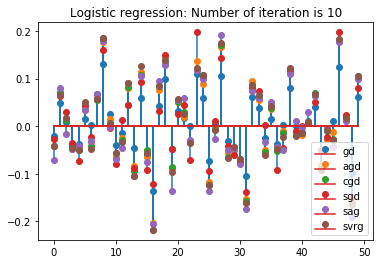

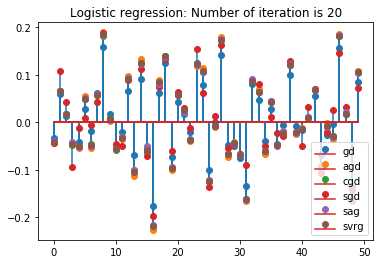

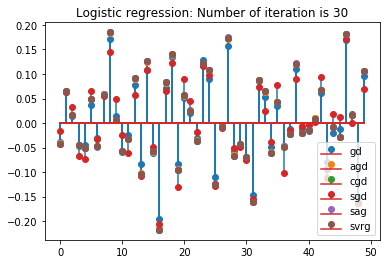

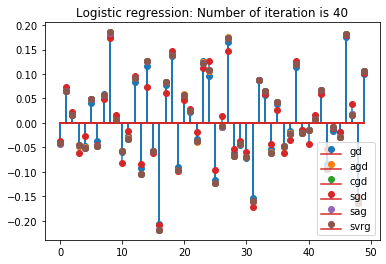

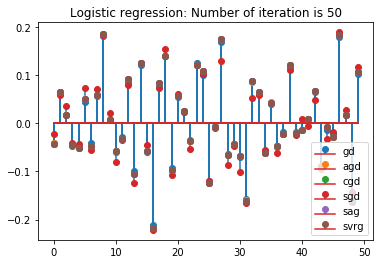

In [45]:
X, y = simu_logreg(w0, corr=0.6)
model = ModelLogReg(X, y, strength=1e-3)

for n_iter in [10, 20,30,40,50]:
    # gradient descent
    callback_gd = inspector(model, n_iter=n_iter,verbose = False)
    w_gd = gd(model, w0, n_iter=n_iter, callback=callback_gd,verbose = False)
    plt.stem(w_gd, use_line_collection=True, label = 'gd',markerfmt = 'C0o')
    #accelereted gradient descent
    callback_agd = inspector(model, n_iter=n_iter,verbose = False)
    w_agd = agd(model, w0, n_iter=n_iter, callback=callback_gd,verbose = False)
    plt.stem(w_agd, use_line_collection=True,label = 'agd',markerfmt = 'C1o')
    #coordinate gradient descent
    callback_cgd = inspector(model, n_iter=n_iter,verbose = False)
    w_cgd = cgd(model, w0, n_iter=n_iter, callback=callback_cgd, verbose = False )
    plt.stem(w_cgd, use_line_collection=True,label = 'cgd', markerfmt = 'C2o')
    
    
    idx_samples = np.random.randint(0, model.n_samples, model.n_samples * n_iter)
    #stochastic gradient descent
    step = 1e-1
    callback_sgd = inspector(model, n_iter=n_iter, verbose = False)
    w_sgd = sgd(model, w0, idx_samples, n_iter=model.n_samples * n_iter, 
                step=step, callback=callback_sgd, verbose = False)
    plt.stem(w_sgd, use_line_collection=True,label = 'sgd', markerfmt = 'C3o')
    
    #stochastic average gradient descent
    step = 1 / model.lip_max()
    callback_sag = inspector(model, n_iter=n_iter, verbose = False)
    w_sag = sag(model, w0, idx_samples, n_iter=model.n_samples * n_iter, 
                step=step, callback=callback_sag, verbose = False)
    plt.stem(w_sag, use_line_collection=True,label = 'sag', markerfmt = 'C4o')
    
    #stochastic variance reduced descent
    step = 1 / model.lip_max()
    callback_svrg = inspector(model, n_iter=n_iter, verbose = False )
    w_svrg = svrg(model, w0, idx_samples, n_iter=model.n_samples * n_iter ,
                  step=step, callback=callback_svrg, verbose = False )
    plt.stem(w_svrg,use_line_collection=True,label = 'svrg', markerfmt = 'C5o')
    
    plt.legend(loc = 'best')
    plt.title('Logistic regression: Number of iteration is {}'.format(n_iter))
    plt.show()

## Question 2

In [46]:
correlation_list = [0, 0.2, 0.4, 0.8, 0.9]

### Test different correlation of features for one algorithm fixed

In [47]:
def test_correlation_algofixed(algo, model_type):
    '''
    Options of argument "algo":
        "gd", "agd", "cgd", "sgd", "sag", "svrg"
        
    Options of argument "model_type":
        "Logistic regression", "Linear regression"
    '''
    callbacks = []
    objectives_min = {}
    for correlation in correlation_list:
        if model_type == "Logistic regression":
            X, y = simu_logreg(w0, corr=correlation)
            model = ModelLogReg(X, y, strength=1e-3)
        elif model_type == "Linear regression":
            X, y = simu_linreg(w0, corr=correlation)
            model = ModelLinReg(X, y, strength=1e-3)
        else: 
            raise ValueError("Unknown model type! Please read the help doc.")
        
#         print("Constant Lips is {}".format(model.lip()) )
        
        callback_long = inspector(model, n_iter=1000, verbose=False)
        w_opt = cgd(model, w0, n_iter=1000, callback=callback_long, verbose=False)
        plt.stem(w_opt, use_line_collection=True, markerfmt = 'C1o')
        plt.title(model_type + ': when correlation is {}, the value of w_opt'.format(correlation))
        plt.show()
        obj_min = callback_long.objectives[-1]
        objectives_min[correlation] = obj_min
        
        if algo in ["gd", "agd", "cgd"]:
            callback = inspector(model, n_iter=n_iter, verbose=False)
            w = eval(algo)(model, w0, n_iter=n_iter, callback=callback, verbose=False)
#             print(w)
            callbacks.append(callback)
        
        elif algo in ["sgd", "sag", "svrg"]:
            if algo == "sgd":
                step = 1e-1
            else:
                step = 1 / model.lip_max()
            
            callback = inspector(model, n_iter=n_iter, verbose=False)
            w = eval(algo)(model, w0, idx_samples, n_iter=model.n_samples*n_iter,
                          step=step, callback=callback, verbose=False)
                
            callbacks.append(callback)
            
        else:
            raise ValueError("Unknown algorithm name! Please read the help doc.")
    
    plt.figure(figsize=(6, 5))
    plt.yscale("log")
    for callback, correlation in zip(callbacks, correlation_list):
        objectives = np.array(callback.objectives)
        objectives_dist = objectives - objectives_min.get(correlation)   
        plt.plot(objectives_dist, label="Correlation={0} ".format(correlation), lw=2)
        
    plt.tight_layout()
    plt.xlim((0, n_iter))
    plt.title(model_type + ", " + algo, fontsize=16)
    plt.xlabel("Number of passes on the data", fontsize=16)
    plt.ylabel(r"$F(w^k) - F(w^*)$", fontsize=16)
    plt.legend(loc='lower right')
    plt.tight_layout()

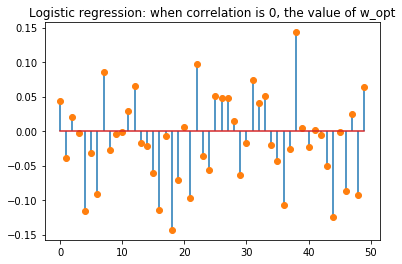

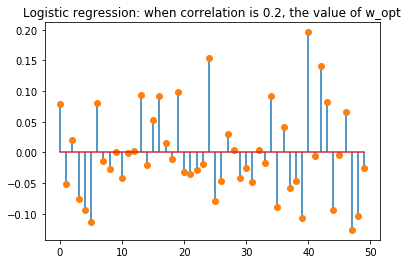

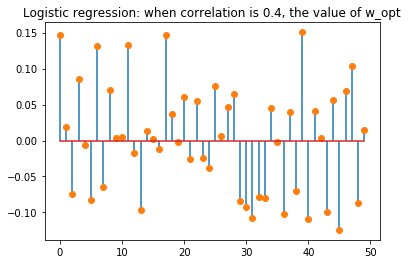

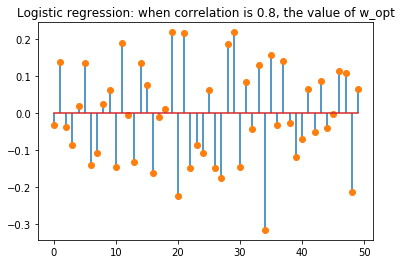

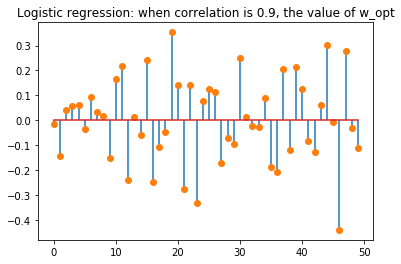

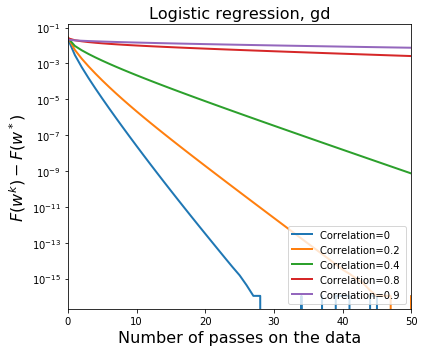

In [48]:
test_correlation_algofixed("gd", "Logistic regression")

## Question 3

### Test different strengthes for one algorithm fixed

In [49]:
strength_list = [100, 10, 1, 1e-2, 1e-4, 1e-6]

In [50]:
X_log, y_log = simu_logreg(w0, corr=0.6)
X_lin, y_lin = simu_linreg(w0, corr=0.6)

In [51]:
def test_strength_algofixed(algo, model_type):
    '''
    Options of argument "algo":
        "gd", "agd", "cgd", "sgd", "sag", "svrg"
        
    Options of argument "model_type":
        "Logistic regression", "Linear regression"
    '''
    callbacks = []
    objectives_min = {}
    
    for s in strength_list:        
        if model_type == "Logistic regression":
            model = ModelLogReg(X_log, y_log, strength=s)
        elif model_type == "Linear regression":
            model = ModelLinReg(X_lin, y_lin, strength=s)
        else: 
            raise ValueError("Unknown model type! Please read the help doc.")
        
        callback_long = inspector(model, n_iter=1000, verbose=False)
        w_opt = cgd(model, w0, n_iter=1000, callback=callback_long, verbose=False)
        plt.stem(w_opt, use_line_collection=True, markerfmt = 'C1o')
        plt.title(model_type + ': when strength is {}, the value of w_opt'.format(s))
        plt.show()
        obj_min = callback_long.objectives[-1]
        objectives_min[s] = obj_min
        
        if algo in ["gd", "agd", "cgd"]:
            callback = inspector(model, n_iter=n_iter, verbose=False)
            w = eval(algo)(model, w0, n_iter=n_iter, callback=callback, verbose=False)
            callbacks.append(callback)
        
        elif algo in ["sgd", "sag", "svrg"]:
            if algo == "sgd":
                step = 1e-1
            else:
                step = 1 / model.lip_max()
            
            callback = inspector(model, n_iter=n_iter, verbose=False)
            w = eval(algo)(model, w0, idx_samples, n_iter=model.n_samples*n_iter,
                          step=step, callback=callback, verbose=False)
                
            callbacks.append(callback)
            
        else:
            raise ValueError("Unknown algorithm name! Please read the help doc.")
    
    plt.figure(figsize=(6, 5))
    plt.yscale("log")
    for callback, strength in zip(callbacks, strength_list):
        objectives = np.array(callback.objectives)
        objectives_dist = objectives - objectives_min.get(strength)   
        plt.plot(objectives_dist, label="Strength={0} ".format(strength), lw=2)
        
    plt.tight_layout()
    plt.xlim((0, n_iter))
    plt.title(model_type + ", " + algo, fontsize=16)
    plt.xlabel("Number of passes on the data", fontsize=16)
    plt.ylabel(r"$F(w^k) - F(w^*)$", fontsize=16)
    plt.legend(loc='lower right')
    plt.tight_layout()

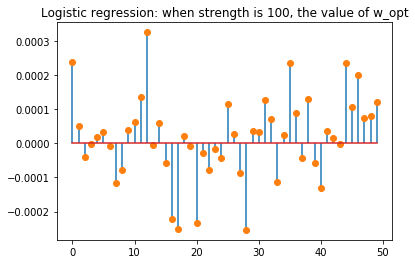

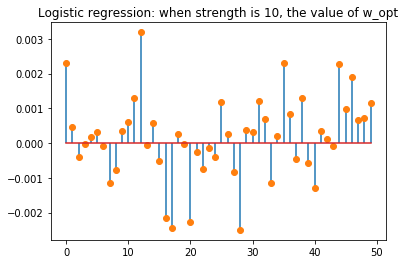

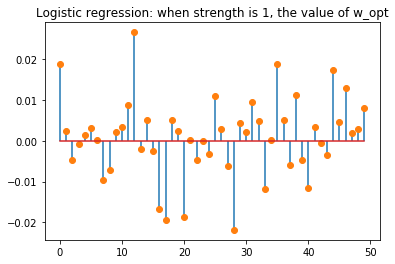

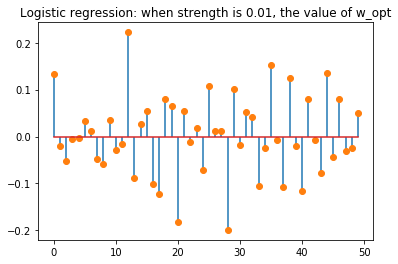

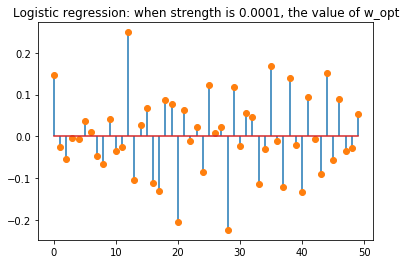

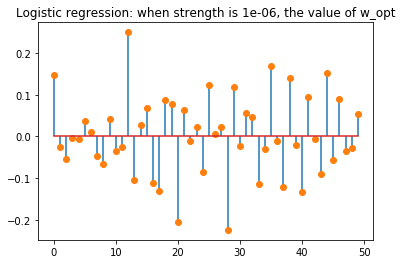

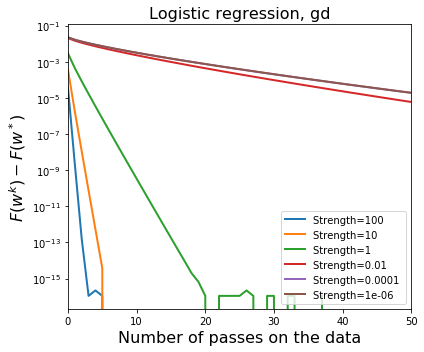

In [52]:
test_strength_algofixed("gd", "Logistic regression")

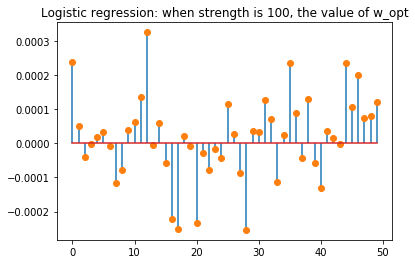

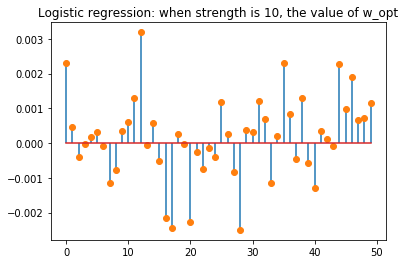

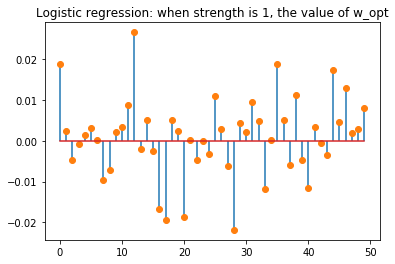

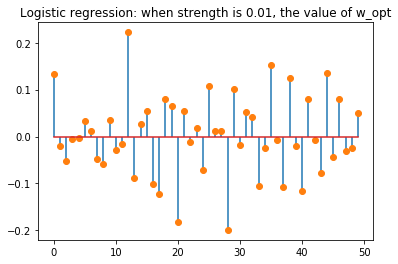

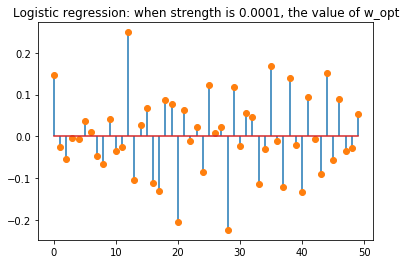

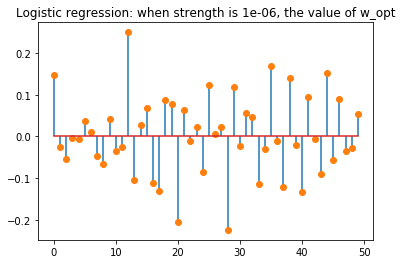

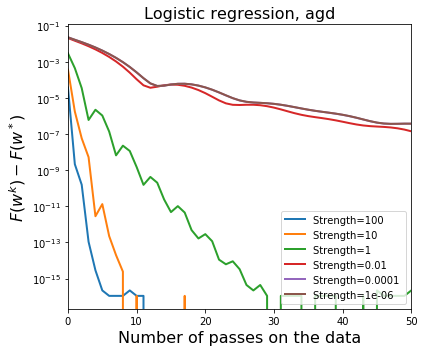

In [53]:
test_strength_algofixed("agd", "Logistic regression")